# Explainable AI project - Part 1 : Training
### Randomized Input Sampling for Explanation of Black-box Models : **RISE**
An implementation on [Imagenette](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz) a subset of ImageNet with 10 classes.

## 1. Models Training

#### 1. Imagenette dataset

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz > /dev/null 2>&1
!tar zxvf imagenette2.tgz > /dev/null 2>&1

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import os
from torch.utils.data import Dataset


means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def get_imagenette2_loaders(root_path='./imagenette2', **kwargs):

    trainset = torchvision.datasets.ImageFolder(os.path.join(root_path, "train"), transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, **kwargs)
    testset = torchvision.datasets.ImageFolder(os.path.join(root_path, "val"), transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, **kwargs)
    return trainloader, testloader

trainloader, testloader = get_imagenette2_loaders( batch_size=64, shuffle=True, num_workers=2)

labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

/home/tortank-el-famoso/miniconda3/envs/XAI/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


(-0.5, 1809.5, 1357.5, -0.5)

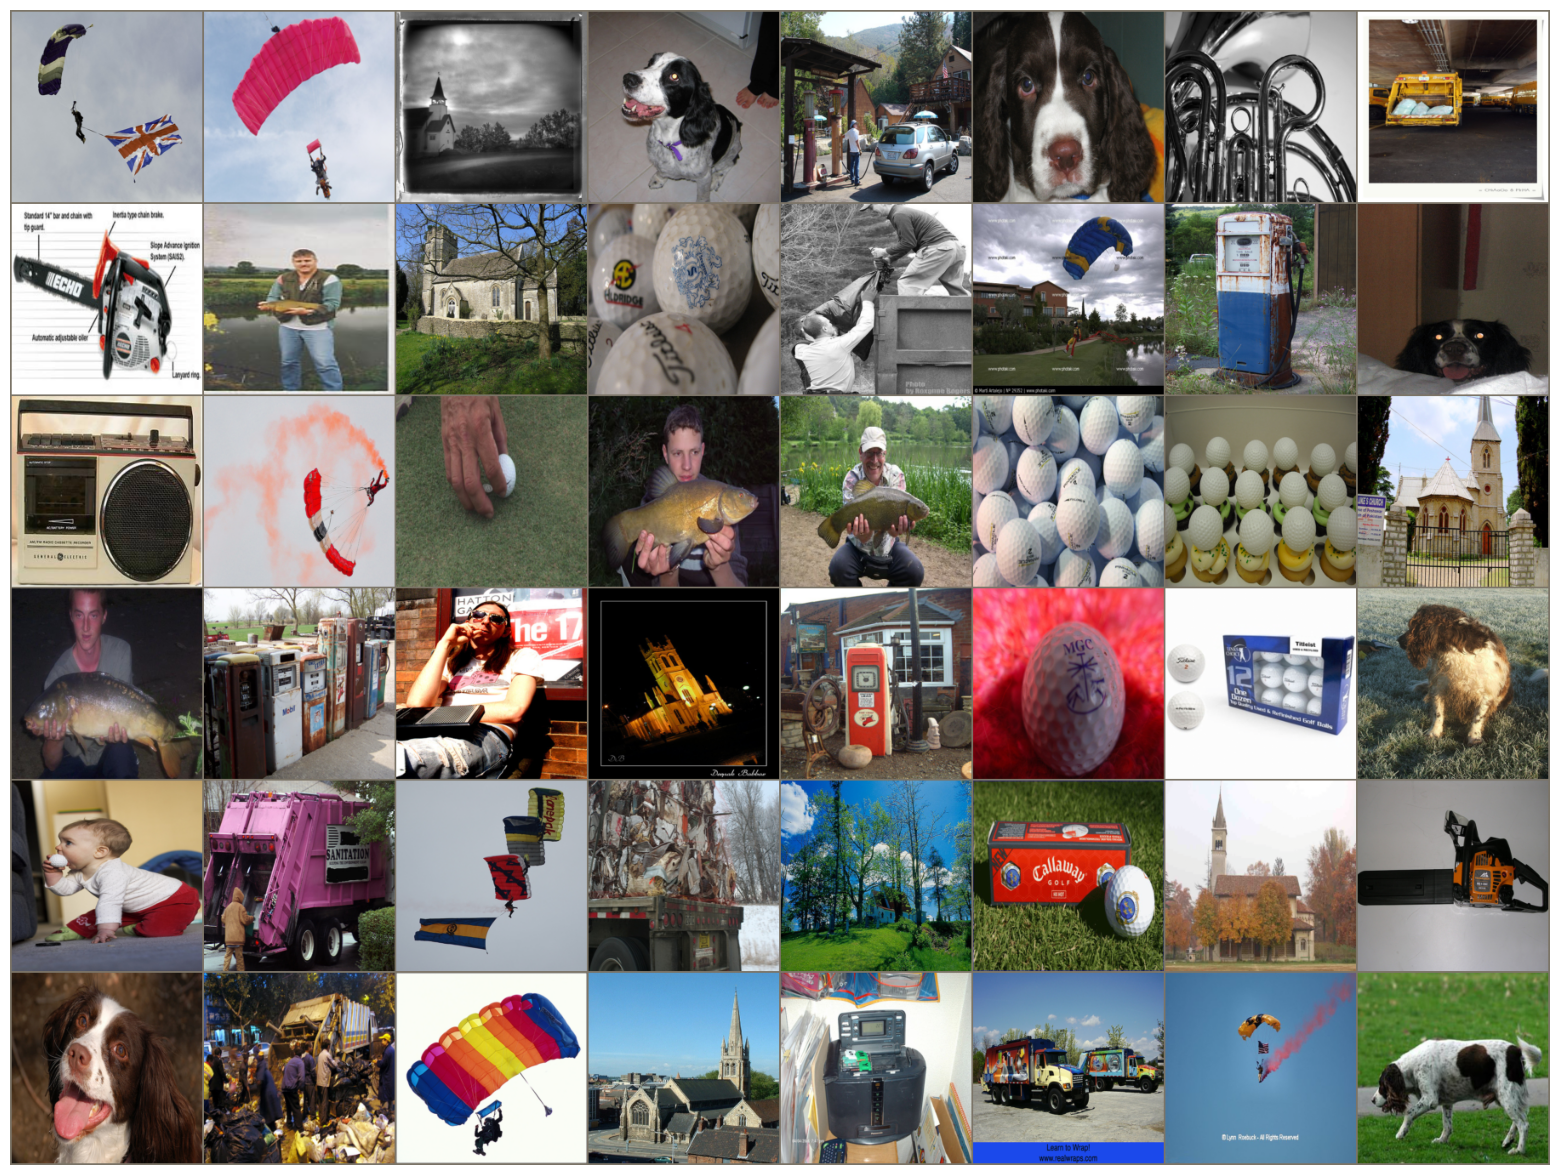

In [2]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(means, stds)],
   std= [1/s for s in stds]
)

x, _ = next(iter(trainloader))
img_grid = make_grid(x[:48])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

#### 2. Models

We choosed two models for the predictions on the Imagenette dataset.

##### 1. ResNet-34 pretrained on ImageNet-1k from [Microsoft](https://huggingface.co/microsoft/resnet-34)
for more informations, consult [*Deep residual learning for image recognition*](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), He, Kaiming and Zhang, Xiangyu and Ren, Shaoqing and Sun, Jian, 2016

/home/tortank-el-famoso/miniconda3/envs/XAI/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=10, bias=True)
)
6
garbage truck


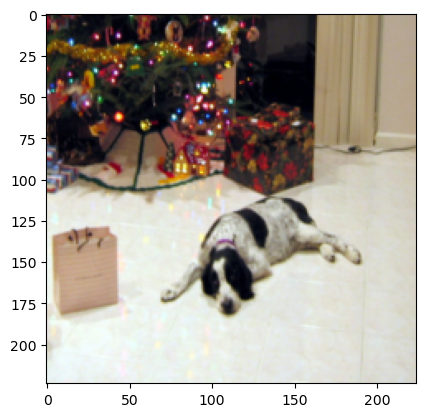

In [3]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch.nn as nn


x, _ = next(iter(trainloader))
image = inv_normalize(x[0])
plt.imshow(inv_normalize(x[0]).permute(1, 2, 0))

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-34")
model_resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")

# Modify the classification layer to have 10 classes
num_features = model_resnet.classifier[1].in_features

classifier = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(num_features, 10)
)

model_resnet.classifier = classifier
print(model_resnet.classifier)

with torch.no_grad():
    logits = model_resnet(image.unsqueez_(0)).logits

# model predicts one of the 10 classes
predicted_label = logits.argmax(-1).item()
print(predicted_label)
print(labels[predicted_label])


##### 2. MobileOne-s1 from [Apple mobile backbone](https://github.com/apple/ml-mobileone)
for more informations, consult [*An Improved One millisecond Mobile Backbone*](https://arxiv.org/pdf/2206.04040), Vasu, Pavan Kumar Anasosalu and Gabriel, James and Zhu, Jeff and Tuzel, Oncel and Ranjan, Anurag, 2022

5
French horn


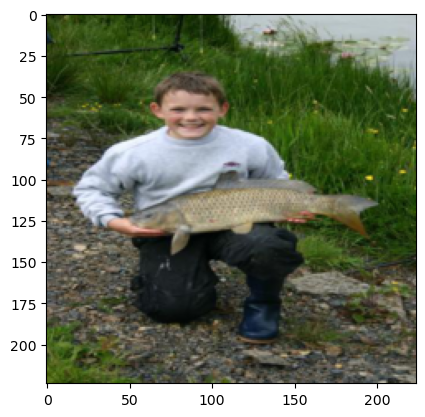

In [4]:
from mobileone import mobileone, reparameterize_model

x, _ = next(iter(trainloader))
image = inv_normalize(x[0])
plt.imshow(inv_normalize(x[0]).permute(1, 2, 0))

# Load Pre-trained checkpoint for fine-tuning
model_mobileone = mobileone(variant='s1')
checkpoint = torch.load('mobileone_s1_unfused.pth.tar', map_location=torch.device('cpu'))
model_mobileone.load_state_dict(checkpoint)

# Change the number of classes in the linear layer to 10
model_mobileone.linear = nn.Linear(in_features=model_mobileone.linear.in_features, out_features=10)

# For inference
model_mobileone.eval()
model_mobileone_eval = reparameterize_model(model_mobileone)

with torch.no_grad():
    logits = model_mobileone_eval(image.unsqueeze_(0))

# model predicts one of the 10 classes
predicted_label = logits.argmax(-1).item()
print(predicted_label)
print(labels[predicted_label])

#### 3. Training

##### 1. ResNet-34

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Freeze all parameters except the classifier
for name, param in model_resnet.named_parameters():
    if "classifier" not in name:  # Exclude classifier parameters
        param.requires_grad = False

# We only train classifier parameters
optimizer = optim.Adam(model_resnet.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Train the classifier
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_resnet.to(device)
model_resnet.train()

losses = []
losses_test = []

print('training ...')

for epoch in range(num_epochs):
    running_loss = 0
    # ------------ Training -------------
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        # One hot labels vector encoding
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        outputs = model_resnet(images)

        loss = criterion(outputs.logits, one_hot_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # ------------ Testing -------------
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(device), labels.to(device)
            # One hot labels vector encoding
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

            outputs = model_resnet(images)

            loss = criterion(outputs.logits, one_hot_labels)

            running_loss += loss.item()

        epoch_loss_test = running_loss / len(testloader)
        losses_test.append(epoch_loss_test)
    
    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Test Loss : {epoch_loss_test}")
    scheduler.step()

cpu
training ...


100%|██████████| 62/62 [01:40<00:00,  1.61s/it]


Epoch 1, Train Loss: 0.45625674774920616, Test Loss : 1.253121557975969


100%|██████████| 62/62 [01:35<00:00,  1.54s/it]


Epoch 2, Train Loss: 0.11409915455088422, Test Loss : 0.38269044801352486


100%|██████████| 62/62 [01:35<00:00,  1.55s/it]


Epoch 3, Train Loss: 0.08576090514936761, Test Loss : 0.3016401067406179


100%|██████████| 62/62 [01:35<00:00,  1.55s/it]


Epoch 4, Train Loss: 0.0707142423410472, Test Loss : 0.2545770836032687


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 5, Train Loss: 0.05877284137406261, Test Loss : 0.22881103161301825


100%|██████████| 62/62 [01:38<00:00,  1.59s/it]


Epoch 6, Train Loss: 0.05061729294184998, Test Loss : 0.20287919347174466


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 7, Train Loss: 0.04611265204683248, Test Loss : 0.1929983727618932


100%|██████████| 62/62 [01:37<00:00,  1.57s/it]


Epoch 8, Train Loss: 0.04478908367329151, Test Loss : 0.1918753597757689


100%|██████████| 62/62 [01:45<00:00,  1.70s/it]


Epoch 9, Train Loss: 0.03816536510979908, Test Loss : 0.17447971297247755


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch 10, Train Loss: 0.03663101427200426, Test Loss : 0.16044581544420292


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch 11, Train Loss: 0.028783870974203218, Test Loss : 0.1402730926976449


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch 12, Train Loss: 0.0301761472884037, Test Loss : 0.14257200827987324


100%|██████████| 62/62 [01:36<00:00,  1.56s/it]


Epoch 13, Train Loss: 0.0277483532475811, Test Loss : 0.1413414571734686


100%|██████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 14, Train Loss: 0.026508464547176216, Test Loss : 0.1328432649644392


100%|██████████| 62/62 [01:36<00:00,  1.56s/it]


Epoch 15, Train Loss: 0.027898425300844718, Test Loss : 0.1465987119515757


100%|██████████| 62/62 [01:36<00:00,  1.56s/it]


Epoch 16, Train Loss: 0.028276871356521606, Test Loss : 0.14183799483092321


100%|██████████| 62/62 [01:36<00:00,  1.56s/it]


Epoch 17, Train Loss: 0.02704240017369188, Test Loss : 0.13920926330460898


100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Epoch 18, Train Loss: 0.027489202534402343, Test Loss : 0.13682474462585825


100%|██████████| 62/62 [01:39<00:00,  1.60s/it]


Epoch 19, Train Loss: 0.027296598929899267, Test Loss : 0.1437570069608609


100%|██████████| 62/62 [01:41<00:00,  1.63s/it]

Epoch 20, Train Loss: 0.027277480914710543, Test Loss : 0.12898990923478718


In [11]:
accuracy_test = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model_resnet(images)
        max_indices = torch.argmax(outputs.logits, dim=1)

        accuracy_test += torch.sum(torch.eq(max_indices, labels)).item()

    accuracy_test = accuracy_test / len(testloader)

print(f"Test Accuracy : {accuracy_test}")

100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

Test Accuracy : 61.935483870967744


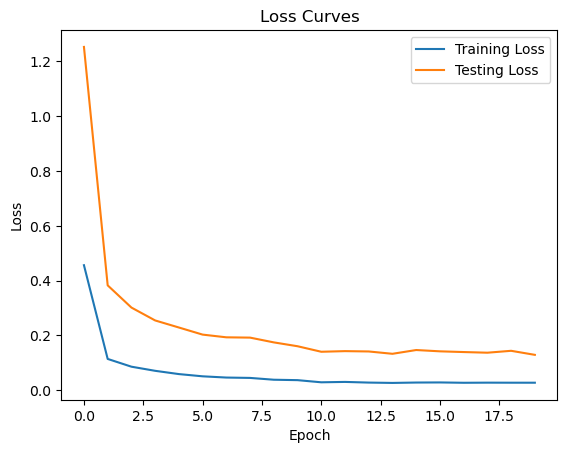

In [6]:
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.plot(losses_test, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [7]:
torch.save(model_resnet.state_dict(), "resnet_34_10_classes_v4.pth")

#V1 = Adam + transfer learning + 2 epochs
#V2 = Adam + transfer learning + 10 epochs
#V3 = Adam + transfer learning + 10 epochs (testing implementation)
#V4 = Adam + transfer learning + 20 epochs + scheduler (at 10, lr/10)

##### 2. MobileOne

cpu
training ...


100%|██████████| 62/62 [03:53<00:00,  3.77s/it]


Epoch 1, Train Loss: 0.13431307613044172, Test Loss : 0.4130857182486403


100%|██████████| 62/62 [03:34<00:00,  3.45s/it]


Epoch 2, Train Loss: 0.06485063982875766, Test Loss : 0.2192191259424773


100%|██████████| 62/62 [04:07<00:00,  3.99s/it]


Epoch 3, Train Loss: 0.049466576241586055, Test Loss : 0.17875848457427515


100%|██████████| 62/62 [03:35<00:00,  3.48s/it]


Epoch 4, Train Loss: 0.03913016045604505, Test Loss : 0.14531651450200908


100%|██████████| 62/62 [03:33<00:00,  3.45s/it]

Epoch 5, Train Loss: 0.03079180884791689, Test Loss : 0.1254882937702801


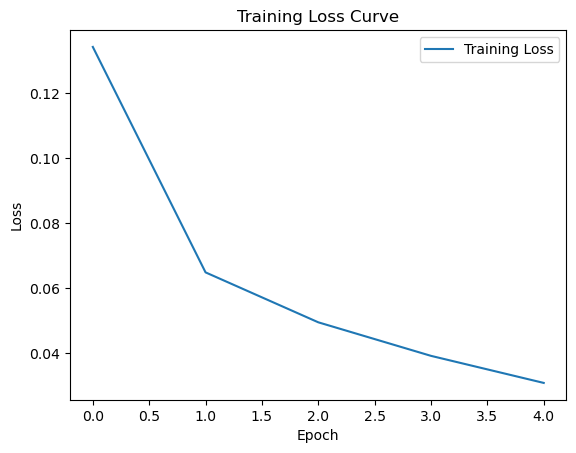

In [15]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

# Freeze the parameters of all layers
for param in model_mobileone.parameters():
    param.requires_grad = False

# Make the parameters of the linear layer trainable
for param in model_mobileone.linear.parameters():
    param.requires_grad = True

# We only train classifier parameters
optimizer = optim.Adam(model_mobileone.linear.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the classifier
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_mobileone.to(device)
model_mobileone.train()

losses = []
losses_test = []

print('training ...')

for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        # One hot labels vector encoding
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()

        outputs = model_mobileone(images)
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # ------------ Testing -------------
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(device), labels.to(device)
            # One hot labels vector encoding
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

            outputs = model_mobileone(images)

            loss = criterion(outputs, one_hot_labels)

            running_loss += loss.item()

        epoch_loss_test = running_loss / (len(testloader)*64)
        losses_test.append(epoch_loss_test)
    
    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Test Loss : {epoch_loss_test}")
    scheduler.step()

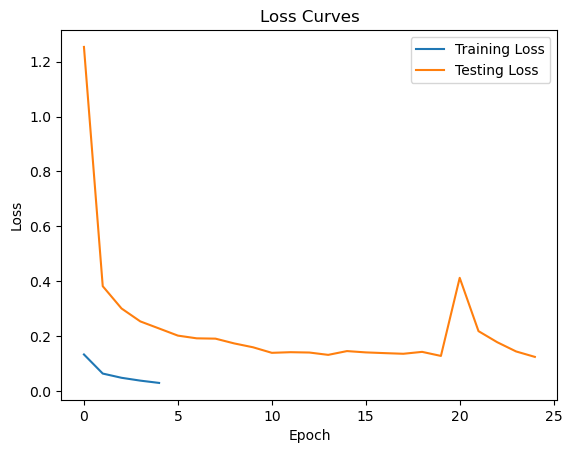

In [16]:
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.plot(losses_test, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [17]:
accuracy_test = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model_mobileone(images)
        max_indices = torch.argmax(outputs, dim=1)

        accuracy_test += torch.sum(torch.eq(max_indices, labels)).item()

    accuracy_test = accuracy_test / (len(testloader)*64)

print(f"Test Accuracy : {accuracy_test}")

100%|██████████| 62/62 [03:38<00:00,  3.53s/it]

Test Accuracy : 62.274193548387096


In [18]:
torch.save(model_mobileone.state_dict(), "mobileone.pth")